# Model 2 - A model which predicts the maximum daily price category based on the provided weather data.

# Energy Price and Demand Analysis and Data Preparation

In [2]:
import pandas as pd
import numpy as np   
import seaborn as sns
%pip install statsmodels 
import statsmodels.api as statsmodels
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report
from statsmodels.tsa.stattools import grangercausalitytests

Note: you may need to restart the kernel to use updated packages.


# Price and Energy Demand Dataset

In [3]:
# load in the price data
price = pd.read_csv('price_demand_data.csv')
display(price.head())

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
0,VIC1,1/01/2021 0:30,4179.21,LOW
1,VIC1,1/01/2021 1:00,4047.76,LOW
2,VIC1,1/01/2021 1:30,3934.70,LOW
3,VIC1,1/01/2021 2:00,3766.45,LOW
4,VIC1,1/01/2021 2:30,3590.37,LOW


In [4]:
price.describe()

,TOTALDEMAND
count,11664.000000
mean,4925.798454
std,876.407490
min,2708.530000
25%,4255.500000
50%,4803.755000
75%,5477.337500
max,8196.830000


In [5]:
# check the data information
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11664 entries, 0 to 11663
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REGION          11664 non-null  object 
 1   SETTLEMENTDATE  11664 non-null  object 
 2   TOTALDEMAND     11664 non-null  float64
 3   PRICECATEGORY   11664 non-null  object 
dtypes: float64(1), object(3)
memory usage: 364.6+ KB


In [6]:
# Detect missing values
price.isna().sum()

REGION            0
SETTLEMENTDATE    0
TOTALDEMAND       0
PRICECATEGORY     0
dtype: int64

In [7]:
# Divide Date & Time into different column
price['Date'] = pd.to_datetime(price['SETTLEMENTDATE'], format='%d/%m/%Y %H:%M').dt.date
price.set_index('Date', inplace=True)
display(price.head())

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
Date,,,,
2021-01-01,VIC1,1/01/2021 0:30,4179.21,LOW
2021-01-01,VIC1,1/01/2021 1:00,4047.76,LOW
2021-01-01,VIC1,1/01/2021 1:30,3934.70,LOW
2021-01-01,VIC1,1/01/2021 2:00,3766.45,LOW
2021-01-01,VIC1,1/01/2021 2:30,3590.37,LOW


Replace the category string ['LOW', 'MEDIUM', 'HIGH', 'EXTREME'] of price category with [1, 2, 3, 4]

In [8]:
price['PRICECATEGORY'].unique()

array(['LOW', 'MEDIUM', 'HIGH', 'EXTREME'], dtype=object)

In [9]:
price['CATEGORYVALUE'] = price['PRICECATEGORY'].replace(['LOW', 'MEDIUM', 'HIGH', 'EXTREME'], [1, 2, 3, 4])
price.describe()

,TOTALDEMAND,CATEGORYVALUE
count,11664.000000,11664.000000
mean,4925.798454,1.461505
std,876.407490,0.716575
min,2708.530000,1.000000
25%,4255.500000,1.000000
50%,4803.755000,1.000000
75%,5477.337500,2.000000
max,8196.830000,4.000000


In [10]:
price['CATEGORYVALUE'].unique()

array([1, 2, 3, 4])

In [11]:
# Calculate the max daily category value
category_price = price.groupby('Date')['CATEGORYVALUE'].max()
display(category_price.head(10))

Date
2021-01-01    1
2021-01-02    1
2021-01-03    1
2021-01-04    1
2021-01-05    1
2021-01-06    1
2021-01-07    1
2021-01-08    2
2021-01-09    2
2021-01-10    2
Name: CATEGORYVALUE, dtype: int64

In [12]:
category_dt = {'LOW':1, 'MEDIUM':2, 'HIGH':3, 'EXTREME':4}

In [13]:
category_price.isna().sum()

0

<AxesSubplot:xlabel='CATEGORYVALUE', ylabel='Density'>

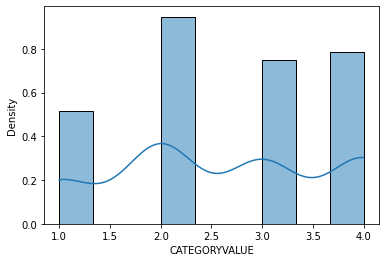

In [14]:
sns.histplot(category_price, kde=True, stat="density")

In [15]:
category_price.values

array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 3, 3, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 2, 2, 2, 3, 1, 1, 1, 2, 2, 2, 2, 1, 2, 3, 4, 2, 3, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 1, 3, 2, 2, 3, 4, 3, 3,
       4, 3, 4, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 3, 2, 4, 4, 3, 2, 4, 4, 4,
       3, 2, 3, 2, 4, 4, 4, 3, 4, 4, 4, 2, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4,
       4, 3, 4, 3, 4, 2, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 3,
       3, 3, 4, 3, 3, 3, 4, 2, 3, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 2,
       4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 2, 2, 3, 2, 3, 4, 4,
       3, 3, 2, 3, 2, 3, 2, 2, 4, 4, 3, 2, 2, 2, 3, 3, 4, 4, 4, 2, 4, 3,
       2, 2])

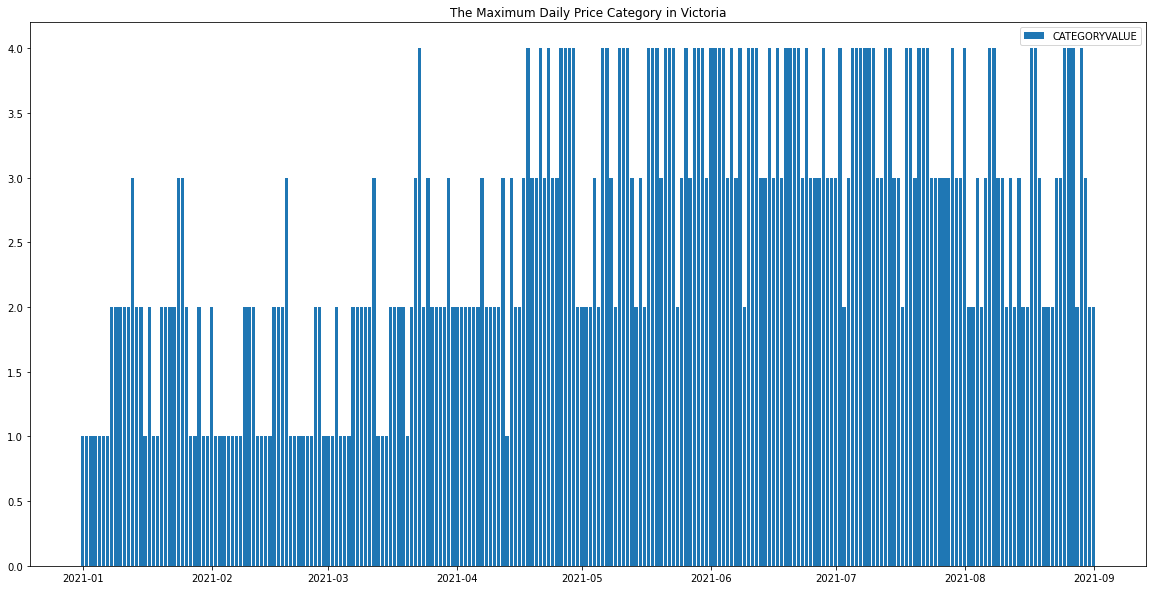

In [16]:
fig = plt.figure(figsize=(20,10))

plt.bar(category_price.index, category_price.values, label = "CATEGORYVALUE")

plt.title("The Maximum Daily Price Category in Victoria")
plt.legend()
plt.show()

In [17]:
category_price.value_counts()

2    77
4    64
3    61
1    42
Name: CATEGORYVALUE, dtype: int64

# Weather Dataset

In [18]:
# load in the weather data
weather = pd.read_csv('weather_data.csv')
display(weather.head())

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [19]:
# reformat the date to be consistant with price_demand dataset
weather['Date'] = pd.to_datetime(weather['Date'], format='%d/%m/%Y').dt.date
weather.set_index('Date', inplace=True)
display(weather.head())

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,
2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [20]:
weather.isna().sum()

Minimum temperature (°C)             1
Maximum temperature (°C)             1
Rainfall (mm)                        2
Evaporation (mm)                     0
Sunshine (hours)                     0
Direction of maximum wind gust       3
Speed of maximum wind gust (km/h)    3
Time of maximum wind gust            3
9am Temperature (°C)                 1
9am relative humidity (%)            1
9am cloud amount (oktas)             0
9am wind direction                   1
9am wind speed (km/h)                1
9am MSL pressure (hPa)               2
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             1
3pm wind direction                   0
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               1
dtype: int64

In [21]:
# Merge daily max category and weather dataframe together
all_data = pd.merge(category_price, weather, how = "right", on = 'Date')
display(all_data.head())

,CATEGORYVALUE,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,1,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,1,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,1,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,1,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,1,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [22]:
# Select numerical features for further analysis
simple_data = all_data[['CATEGORYVALUE', 'Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)','Speed of maximum wind gust (km/h)', '9am Temperature (°C)', '9am relative humidity (%)','9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)', '3pm relative humidity (%)','3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)']]
display(simple_data.head())

,CATEGORYVALUE,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,
2021-01-01,1,15.6,29.9,0.0,2.8,9.3,31.0,19.2,77.0,6,2,1018.8,28.1,43,5.0,13,1015.3
2021-01-02,1,18.4,29.0,0.0,9.4,1.3,30.0,23.3,52.0,7,17,1013.3,28.7,38,7.0,4,1008.5
2021-01-03,1,17.0,26.2,12.6,4.8,7.1,33.0,18.3,100.0,8,4,1007.7,23.5,59,4.0,2,1005.2
2021-01-04,1,16.0,18.6,2.6,3.8,0.0,41.0,16.2,98.0,8,11,1010.0,18.2,82,8.0,17,1011.0
2021-01-05,1,15.9,19.1,11.2,1.0,0.0,35.0,17.2,96.0,8,13,1012.5,18.2,82,8.0,19,1013.3


In [23]:
# Check missing data
simple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 2021-01-01 to 2021-08-31
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CATEGORYVALUE                      243 non-null    int64  
 1   Minimum temperature (°C)           242 non-null    float64
 2   Maximum temperature (°C)           242 non-null    float64
 3   Rainfall (mm)                      241 non-null    float64
 4   Evaporation (mm)                   243 non-null    float64
 5   Sunshine (hours)                   243 non-null    float64
 6   Speed of maximum wind gust (km/h)  240 non-null    float64
 7   9am Temperature (°C)               242 non-null    float64
 8   9am relative humidity (%)          242 non-null    float64
 9   9am cloud amount (oktas)           243 non-null    int64  
 10  9am wind speed (km/h)              242 non-null    object 
 11  9am MSL pressure (hPa)             241 non-null

In [24]:
# Replace Calm to 0
simple_data = simple_data.replace('Calm', '0', regex=True)

In [25]:
## Convert data type
simple_data ['9am wind speed (km/h)'] = pd.to_numeric(simple_data['9am wind speed (km/h)'])
simple_data ['3pm wind speed (km/h)'] = pd.to_numeric(simple_data['3pm wind speed (km/h)'])

In [26]:
# Replace Blank Values with NaN
simple_data.replace(np.nan, 0)

# Replace NaN values by mean of each column
simple_data.fillna(simple_data.mean(), inplace=True)

In [27]:
# Check Again - missing data
simple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 2021-01-01 to 2021-08-31
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CATEGORYVALUE                      243 non-null    int64  
 1   Minimum temperature (°C)           243 non-null    float64
 2   Maximum temperature (°C)           243 non-null    float64
 3   Rainfall (mm)                      243 non-null    float64
 4   Evaporation (mm)                   243 non-null    float64
 5   Sunshine (hours)                   243 non-null    float64
 6   Speed of maximum wind gust (km/h)  243 non-null    float64
 7   9am Temperature (°C)               243 non-null    float64
 8   9am relative humidity (%)          243 non-null    float64
 9   9am cloud amount (oktas)           243 non-null    int64  
 10  9am wind speed (km/h)              243 non-null    float64
 11  9am MSL pressure (hPa)             243 non-null

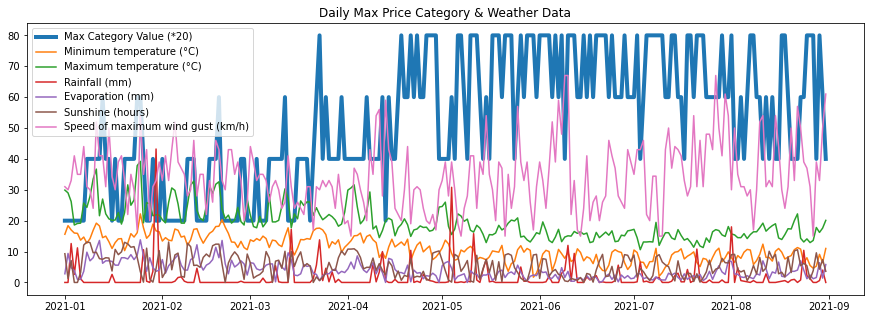

In [28]:
# Plotting selected features for Melbourne between January and August 2021
max_category = simple_data['CATEGORYVALUE'] * 20 
min_temp = simple_data['Minimum temperature (°C)']
max_temp = simple_data['Maximum temperature (°C)']
rainfall = simple_data['Rainfall (mm)']
evaporation = simple_data['Evaporation (mm)']
sunshine = simple_data['Sunshine (hours)']
speed_of_maximum_wind_gust = simple_data['Speed of maximum wind gust (km/h)']


fig = plt.figure(figsize=(15,5))
plt.plot(max_category, label = "Max Category Value (*20)", linewidth = 4)
plt.plot(min_temp, label = "Minimum temperature (°C)")
plt.plot(max_temp, label = "Maximum temperature (°C)")
plt.plot(rainfall, label = "Rainfall (mm)")
plt.plot(evaporation, label = "Evaporation (mm)")
plt.plot(sunshine, label = "Sunshine (hours)")
plt.plot(speed_of_maximum_wind_gust, label = "Speed of maximum wind gust (km/h)")
plt.title("Daily Max Price Category & Weather Data")
plt.legend()
plt.show()

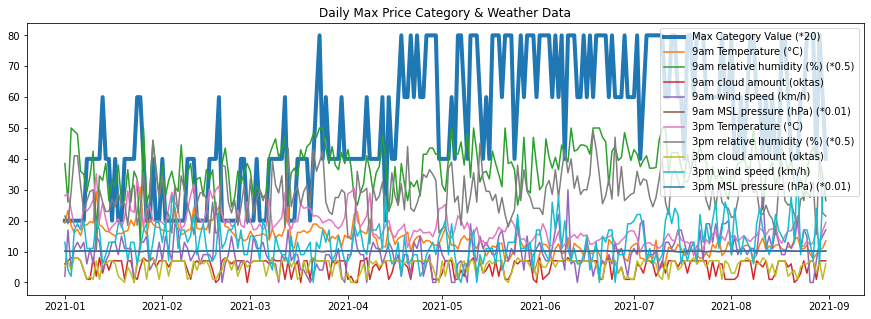

In [29]:
# Plotting selected features for Melbourne between January and August 2021
max_category = simple_data['CATEGORYVALUE'] * 20 
am_Temperature = simple_data['9am Temperature (°C)']
am_relative_humidity = simple_data['9am relative humidity (%)'] * 0.5
am_cloud_amount = simple_data['9am cloud amount (oktas)']
am_wind_speed = simple_data['9am wind speed (km/h)' ]
am_MSL_pressure = simple_data['9am MSL pressure (hPa)'] * 0.01
pm_Temperature = simple_data['3pm Temperature (°C)']
pm_relative_humidity = simple_data['3pm relative humidity (%)'] * 0.5
pm_cloud_amount = simple_data['3pm cloud amount (oktas)']
pm_wind_speed = simple_data['3pm wind speed (km/h)'] 
pm_MSL_pressure = simple_data['3pm MSL pressure (hPa)'] * 0.01


fig = plt.figure(figsize=(15,5))
plt.plot(max_category, label = "Max Category Value (*20)", linewidth = 4)
plt.plot(am_Temperature, label = '9am Temperature (°C)')
plt.plot(am_relative_humidity, label = '9am relative humidity (%) (*0.5)')
plt.plot(am_cloud_amount, label = '9am cloud amount (oktas)')
plt.plot(am_wind_speed, label = '9am wind speed (km/h)')
plt.plot(am_MSL_pressure, label = '9am MSL pressure (hPa) (*0.01)')
plt.plot(pm_Temperature, label = '3pm Temperature (°C)')
plt.plot(pm_relative_humidity, label = '3pm relative humidity (%) (*0.5)')
plt.plot(pm_cloud_amount, label = '3pm cloud amount (oktas)')
plt.plot(pm_wind_speed, label = '3pm wind speed (km/h)')
plt.plot(pm_MSL_pressure, label = '3pm MSL pressure (hPa) (*0.01)')
plt.title("Daily Max Price Category & Weather Data")
plt.legend(loc='upper right')
plt.show()

# Feature Selection

We will perform Granger’s causality test, it’s possible to test the relationship between each feature. 
The null hypothesis is that the values of the other features (x) do not cause CATEGORYVALUE (y).
If the tested p-value is less than the significance level (we use 0.05).
Then, we can reject the null hypothesis and indicate that the values of the other features (x) do cause CATEGORYVALUE (y).

In [30]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(simple_data, variables = simple_data.columns)

,CATEGORYVALUE_x,Minimum temperature (°C)_x,Maximum temperature (°C)_x,Rainfall (mm)_x,Evaporation (mm)_x,Sunshine (hours)_x,Speed of maximum wind gust (km/h)_x,9am Temperature (°C)_x,9am relative humidity (%)_x,9am cloud amount (oktas)_x,9am wind speed (km/h)_x,9am MSL pressure (hPa)_x,3pm Temperature (°C)_x,3pm relative humidity (%)_x,3pm cloud amount (oktas)_x,3pm wind speed (km/h)_x,3pm MSL pressure (hPa)_x
CATEGORYVALUE_y,1.0000,0.0000,0.0000,0.0202,0.0000,0.0196,0.0509,0.0000,0.7388,0.0313,0.0989,0.0106,0.0000,0.1227,0.4037,0.0696,0.0064
Minimum temperature (°C)_y,0.0000,1.0000,0.0000,0.0638,0.0139,0.0000,0.0065,0.0000,0.2189,0.0369,0.0139,0.0152,0.0000,0.0000,0.0002,0.0052,0.0009
Maximum temperature (°C)_y,0.0001,0.0002,1.0000,0.1980,0.0641,0.0000,0.0000,0.0000,0.0066,0.0381,0.0006,0.0000,0.0005,0.0119,0.0000,0.0543,0.0000
Rainfall (mm)_y,0.1087,0.0008,0.0004,1.0000,0.0344,0.0000,0.0083,0.0016,0.1858,0.0551,0.2996,0.0000,0.0000,0.0000,0.0001,0.4226,0.0000
Evaporation (mm)_y,0.0000,0.0000,0.0000,0.0004,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0654,0.0088,0.0000,0.0000,0.0000,0.0000,0.0000
Sunshine (hours)_y,0.0041,0.0007,0.0016,0.0483,0.0168,1.0000,0.0244,0.0188,0.1002,0.0003,0.2373,0.1102,0.0001,0.0013,0.0141,0.2134,0.0383
Speed of maximum wind gust (km/h)_y,0.1273,0.1475,0.2234,0.1041,0.6805,0.4345,1.0000,0.1223,0.0256,0.0678,0.2928,0.0707,0.2076,0.1431,0.1700,0.0250,0.0039
9am Temperature (°C)_y,0.0000,0.0080,0.0000,0.0558,0.0657,0.0000,0.0005,1.0000,0.0000,0.0750,0.0001,0.0057,0.0000,0.0000,0.0000,0.2158,0.0542
9am relative humidity (%)_y,0.0004,0.0828,0.0003,0.4559,0.0462,0.0008,0.0589,0.1832,1.0000,0.1094,0.1589,0.4878,0.0003,0.0000,0.0489,0.0044,0.3829
9am cloud amount (oktas)_y,0.0096,0.0530,0.2224,0.4909,0.2836,0.0178,0.1593,0.1463,0.2407,1.0000,0.5499,0.0031,0.1298,0.0122,0.0000,0.1047,0.0039


The rows are the response (y) and the columns are the predictor series (x). For example, if we take the P-value 0.0000 in (row 'Minimum temperature (°C)_y', column 'CATEGORYVALUE_x'), it refers to the P-value of 'CATEGORYVALUE_x' causing 'Minimum temperature (°C)_y'. Here, we are looking at the first row - CATEGORYVALUE as the target variable (y) and the rest of the variables as the predictors (x). The P-values for Speed of maximum wind gust (km/h), 9am relative humidity (%), 9am wind speed (km/h), 9am MSL pressure (hPa), 3pm relative humidity (%), 3pm cloud amount (oktas), 3pm wind speed (km/h), 3pm MSL pressure (hPa) are greater than 0.05, which means that the variables in these dataset are not influencing the CATEGORYVALUE. The P-values for the rest are all less than 0.05, which means that all the variables in the dataset are influencing the total demand of energy. Hence, we will keep Minimum temperature (°C)_x, Maximum temperature (°C)_x, Rainfall (mm), Evaporation (mm)_x, Sunshine (hours)_x, 9am Temperature (°C)_x, 9am cloud amount (oktas)_x and 3pm Temperature (°C)_x, and conduct train-validation-test split next.

In [31]:
simple_data.columns

Index(['CATEGORYVALUE', 'Minimum temperature (°C)', 'Maximum temperature (°C)',
       'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)',
       'Speed of maximum wind gust (km/h)', '9am Temperature (°C)',
       '9am relative humidity (%)', '9am cloud amount (oktas)',
       '9am wind speed (km/h)', '9am MSL pressure (hPa)',
       '3pm Temperature (°C)', '3pm relative humidity (%)',
       '3pm cloud amount (oktas)', '3pm wind speed (km/h)',
       '3pm MSL pressure (hPa)'],
      dtype='object')

In [32]:
# Drop data
simple_data = simple_data.drop(columns=['Speed of maximum wind gust (km/h)', '9am relative humidity (%)', '9am wind speed (km/h)', 
                                        '9am MSL pressure (hPa)', '3pm relative humidity (%)', '3pm cloud amount (oktas)', 
                                        '3pm wind speed (km/h)', '3pm MSL pressure (hPa)'])
display(simple_data.head())

,CATEGORYVALUE,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),9am Temperature (°C),9am cloud amount (oktas),3pm Temperature (°C)
Date,,,,,,,,,
2021-01-01,1,15.6,29.9,0.0,2.8,9.3,19.2,6,28.1
2021-01-02,1,18.4,29.0,0.0,9.4,1.3,23.3,7,28.7
2021-01-03,1,17.0,26.2,12.6,4.8,7.1,18.3,8,23.5
2021-01-04,1,16.0,18.6,2.6,3.8,0.0,16.2,8,18.2
2021-01-05,1,15.9,19.1,11.2,1.0,0.0,17.2,8,18.2


In [33]:
# Replace Blank Values with NaN
simple_data.replace(np.nan, 0)

# Replace NaN values by mean of each column
simple_data.fillna(simple_data.mean(), inplace=True)

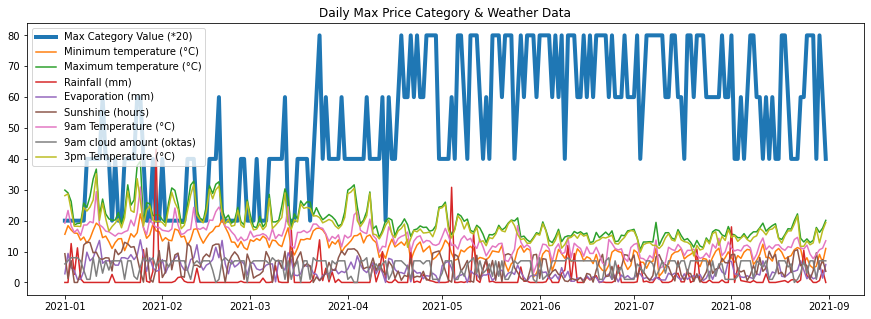

In [34]:
# plotting features that influencing Max Category value for Melbourne between January and August 2021
max_category = simple_data['CATEGORYVALUE'] * 20 
min_temp = simple_data['Minimum temperature (°C)']
max_temp = simple_data['Maximum temperature (°C)']
rainfall = simple_data['Rainfall (mm)']
evaporation = simple_data['Evaporation (mm)']
sunshine = simple_data['Sunshine (hours)']
am_Temperature = simple_data['9am Temperature (°C)']
am_cloud_amount = simple_data['9am cloud amount (oktas)']
pm_Temperature = simple_data['3pm Temperature (°C)']

fig = plt.figure(figsize=(15,5))
plt.plot(max_category, label = "Max Category Value (*20)", linewidth = 4)
plt.plot(min_temp, label = "Minimum temperature (°C)")
plt.plot(max_temp, label = "Maximum temperature (°C)")
plt.plot(rainfall, label = "Rainfall (mm)")
plt.plot(evaporation, label = "Evaporation (mm)")
plt.plot(sunshine, label = "Sunshine (hours)")
plt.plot(am_Temperature, label = '9am Temperature (°C)')
plt.plot(am_cloud_amount, label = '9am cloud amount (oktas)')
plt.plot(pm_Temperature, label = '3pm Temperature (°C)')
plt.title("Daily Max Price Category & Weather Data")
plt.legend()
plt.show()

In [35]:
# Checking correlation - positive or negative correlation
correlation = simple_data.corr()

<AxesSubplot:>

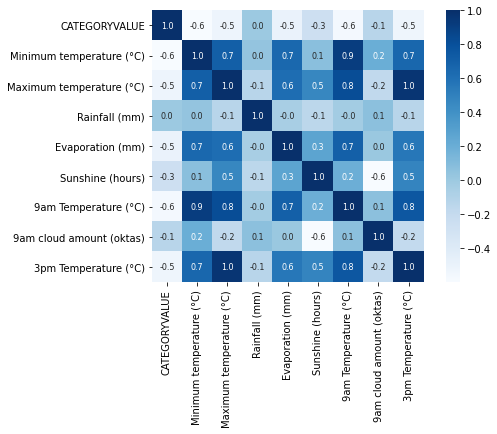

In [36]:
# consruction a heatmap to understand correlation
plt.figure(figsize = (8, 5))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [37]:
# correlation values of Categoryvalue
print(correlation['CATEGORYVALUE'])

CATEGORYVALUE               1.000000
Minimum temperature (°C)   -0.599024
Maximum temperature (°C)   -0.514404
Rainfall (mm)               0.011632
Evaporation (mm)           -0.488360
Sunshine (hours)           -0.251258
9am Temperature (°C)       -0.565200
9am cloud amount (oktas)   -0.125458
3pm Temperature (°C)       -0.519353
Name: CATEGORYVALUE, dtype: float64


# Training & Testing (Random Forest) 

The random forest model I used randomly split the data into 7:2:1, and calculated the confusion matrix, accuracy rate, regression rate, and f1 value for the verification set and test set respectively.

In [38]:
# Train-Validation-Test Split
train_X, temp_X, train_y, temp_y = train_test_split(simple_data.iloc[:, 1:],simple_data.iloc[:, 0],test_size=0.3,random_state=5)
test_X, val_X, test_y, val_y = train_test_split(temp_X, temp_y,test_size=0.3,random_state=5)

In [39]:
print("The length of train set: ", len(train_X))
print("The length of val set: ", len(val_X))
print("The length of test set: ", len(test_X))

The length of train set:  170
The length of val set:  22
The length of test set:  51


In [40]:
# Create model and training
model = RandomForestClassifier(n_estimators=50, random_state=2020)
model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=50, random_state=2020)

In [41]:
print("Accuracy of training: ", model.score(train_X, train_y))
print("Accuracy of val: ", model.score(val_X, val_y))
print("Accuracy of test: ", model.score(test_X, test_y))

Accuracy of training:  1.0
Accuracy of val:  0.6363636363636364
Accuracy of test:  0.49019607843137253


In [42]:
def create_confusion_matrix(test_y, pred_y):
    confusion_matrix = [[0]* 4 for _ in range(4)]
    for i in range(4):
        for j in range(4):
            confusion_matrix[i][j] = sum(pred_y[test_y == i] == j)
    return confusion_matrix

#### Evaluation metrics for the test set

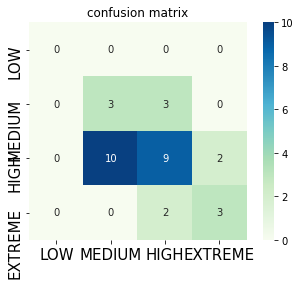

In [43]:

pred_y = model.predict(test_X)
confusion_matrix = create_confusion_matrix(test_y.values, pred_y)
confusion_matrix
#plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
ax = sns.heatmap(confusion_matrix, xticklabels=['LOW', 'MEDIUM', 'HIGH', 'EXTREME'], yticklabels=['LOW', 'MEDIUM', 'HIGH', 'EXTREME'], square=True, annot=True, cmap="GnBu")
plt.title("confusion matrix")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [44]:
res = classification_report(test_y.values, pred_y)
res.split('\n')

['              precision    recall  f1-score   support',
 '',
 '           1       0.23      0.50      0.32         6',
 '           2       0.64      0.39      0.49        23',
 '           3       0.33      0.38      0.35         8',
 '           4       0.67      0.71      0.69        14',
 '',
 '    accuracy                           0.49        51',
 '   macro avg       0.47      0.50      0.46        51',
 'weighted avg       0.55      0.49      0.50        51',
 '']

#### Evaluation metrics for the validation set

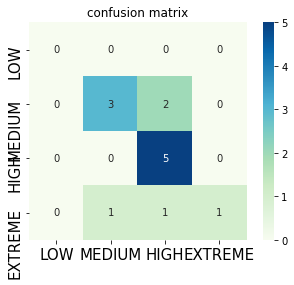

In [45]:
pred_y = model.predict(val_X)
confusion_matrix = create_confusion_matrix(val_y.values, pred_y)
confusion_matrix
#plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
ax = sns.heatmap(confusion_matrix, xticklabels=['LOW', 'MEDIUM', 'HIGH', 'EXTREME'], yticklabels=['LOW', 'MEDIUM', 'HIGH', 'EXTREME'], square=True, annot=True, cmap="GnBu")
plt.title("confusion matrix")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [46]:
res = classification_report(val_y.values, pred_y)
res.split('\n')

['              precision    recall  f1-score   support',
 '',
 '           1       0.75      0.60      0.67         5',
 '           2       0.56      1.00      0.71         5',
 '           3       0.50      0.20      0.29         5',
 '           4       0.71      0.71      0.71         7',
 '',
 '    accuracy                           0.64        22',
 '   macro avg       0.63      0.63      0.60        22',
 'weighted avg       0.64      0.64      0.61        22',
 '']